In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

In [2]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)

    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [3]:
class Discriminator():
    def __init__(self):
        self.param_list = []
        self.input_shape = (None, 784)
        self.__create_variable()

    def __create_variable(self):
        with tf.name_scope('discriminator'):
            self.__D_W1 = tf.Variable(xavier_init([784, 128]), name='D_W1')
            self.__D_b1 = tf.Variable(tf.zeros(shape=[128]), name='D_b1')
            self.param_list.append(self.__D_W1)
            self.param_list.append(self.__D_b1)

            self.__D_W2 = tf.Variable(xavier_init([128, 1]), name='D_W2')
            self.__D_b2 = tf.Variable(tf.zeros(shape=[1]), name='D_b2')
            self.param_list.append(self.__D_W2)
            self.param_list.append(self.__D_b2)

    def run(self, x):
        D_h1 = tf.nn.relu(tf.matmul(x, self.__D_W1) + self.__D_b1)
        D_logit = tf.matmul(D_h1, self.__D_W2) + self.__D_b2
        D_prob = tf.nn.sigmoid(D_logit)

        return D_prob, D_logit


class Generator():
    def __init__(self):
        self.param_list = []
        self.input_shape = (None, 100)
        self.__create_variable()

    def __create_variable(self):
        with tf.name_scope('generator'):
            self.__G_W1 = tf.Variable(xavier_init([100, 128]), name='G_W1')
            self.__G_b1 = tf.Variable(tf.zeros(shape=[128]), name='G_b1')
            self.param_list.append(self.__G_W1)
            self.param_list.append(self.__G_b1)

            self.__G_W2 = tf.Variable(xavier_init([128, 784]), name='G_W2')
            self.__G_b2 = tf.Variable(tf.zeros(shape=[784]), name='G_b2')
            self.param_list.append(self.__G_W2)
            self.param_list.append(self.__G_b2)

    def run(self, z):
        G_h1 = tf.nn.relu(tf.matmul(z, self.__G_W1) + self.__G_b1)
        G_logit = tf.matmul(G_h1, self.__G_W2) + self.__G_b2
        G_prob = tf.nn.sigmoid(G_logit)

        return G_prob, G_logit


class Sample():
    def __init__(self):
        pass

    def uniform_sample(self, m, n):
        return np.random.uniform(-1., 1., size=[m, n])

    def normal_sample(self, mean, std, m, n):
        sample = np.zeros([m, n])
        for piexl in range(0, n):
            sample[:, piexl] = np.random.normal(mean[piexl], 10 * std[piexl],
                                                m)

        return sample


class GAN():
    def __init__(self,
                 sample=None,
                 generator=None,
                 discriminator=None,
                 training_rate=1e-4):
        if sample is None:
            self.sample = Sample()
        else:
            self.sample = sample
        if generator is None:
            self.generator = Generator()
        else:
            self.generator = generator
        if discriminator is None:
            self.discriminator = Discriminator()
        else:
            self.discriminator = discriminator
        self.training_rate = training_rate

        self.__create_placeholder()
        self.__create_train_graph()

    def __create_placeholder(self):
        self.X = tf.placeholder(
            tf.float32, shape=self.discriminator.input_shape)
        self.Z = tf.placeholder(tf.float32, shape=self.generator.input_shape)

    def __create_train_graph(self):
        G_sample, _ = self.generator.run(self.Z)
        D_prob_real, D_logit_real = self.discriminator.run(self.X)
        D_prob_fake, D_logit_fake = self.discriminator.run(G_sample)
        D_loss_real = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
        D_loss_fake = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
        D_loss = D_loss_real + D_loss_fake
        G_loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

        D_solver = tf.train.AdamOptimizer().minimize(
            D_loss, var_list=self.discriminator.param_list)
        G_solver = tf.train.AdamOptimizer().minimize(
            G_loss, var_list=self.generator.param_list)

        self.G_sample = G_sample
        self.D_solver = D_solver
        self.G_solver = G_solver
        self.D_loss = D_loss
        self.G_loss = G_loss

In [4]:
class ModelConfig():
    def __init__(self,
                 batch_size=100,
                 max_epoch=200,
                 plot_epoch=5,
                 z_dim=100,
                 K=1,
                 R=1):
        self.batch_size = batch_size
        self.max_epoch = max_epoch
        self.plot_epoch = plot_epoch
        self.z_dim = z_dim
        self.K = K
        self.R = R

In [6]:
def plot_sample(samples):
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(10, 10)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig


def plot_loss(G_iteration_list, G_loss_list, D_iteration_list, D_loss_list):
    fig = plt.figure()
    plt.plot(G_iteration_list, G_loss_list, 'r')
    plt.plot(D_iteration_list, D_loss_list, 'y')
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.legend(['G_loss', 'D_loss'])
    plt.title("G_loss VS D_loss")
    return fig


Extracting mnist/data/train-images-idx3-ubyte.gz
Extracting mnist/data/train-labels-idx1-ubyte.gz
Extracting mnist/data/t10k-images-idx3-ubyte.gz
Extracting mnist/data/t10k-labels-idx1-ubyte.gz
epoch : 0


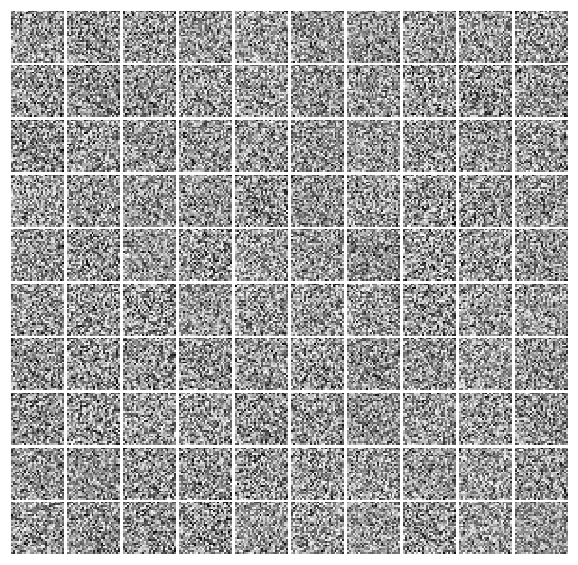

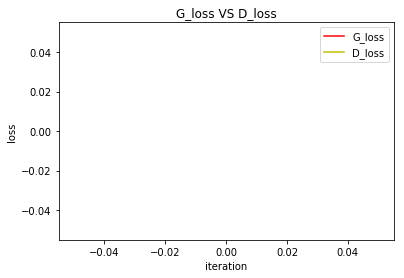

epoch : 5


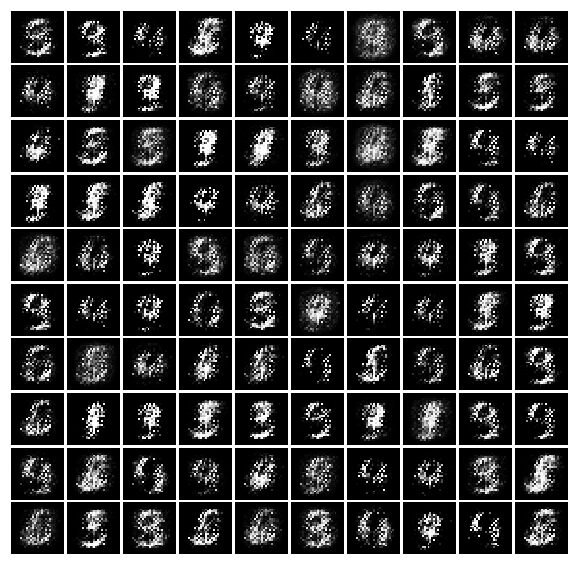

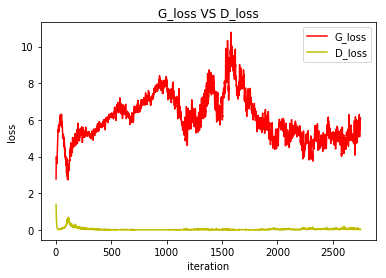

epoch : 10


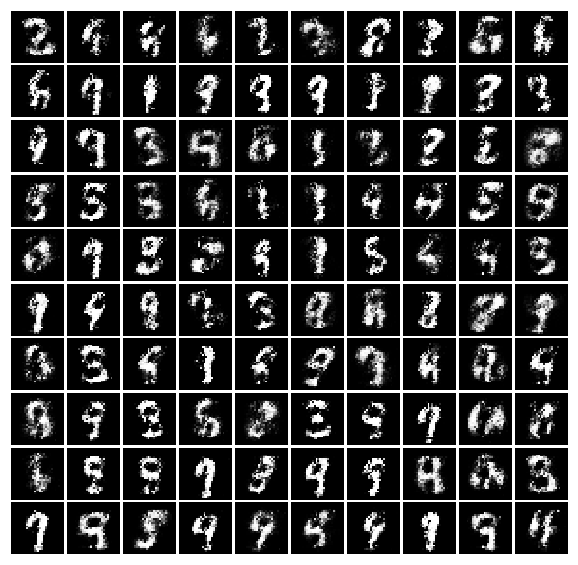

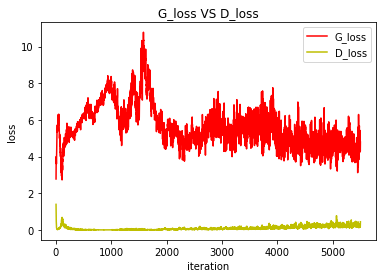

epoch : 15


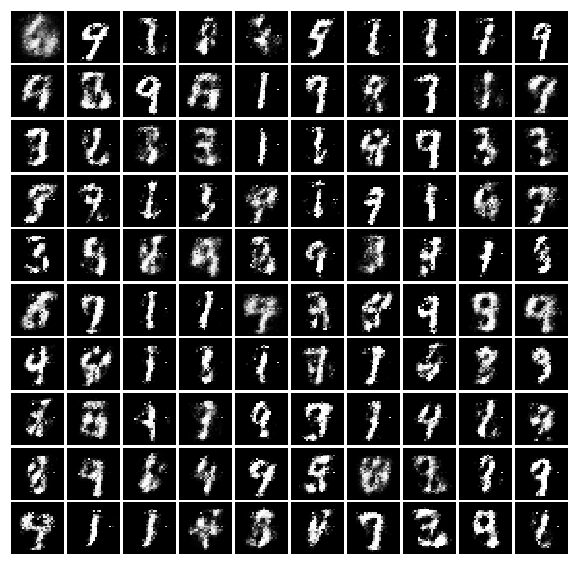

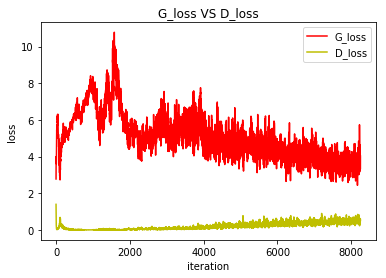

epoch : 20


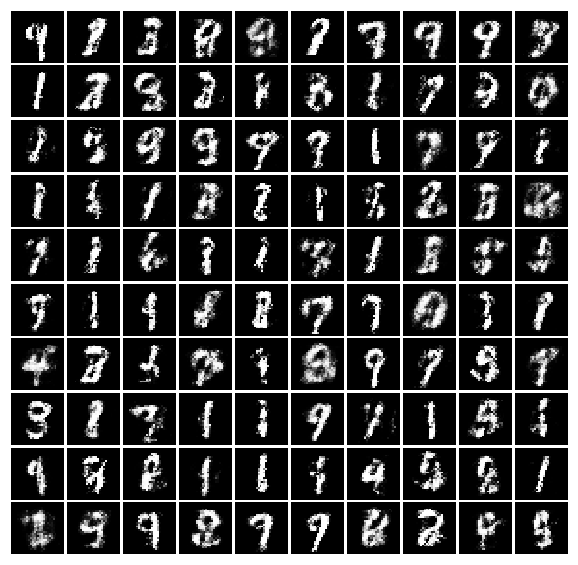

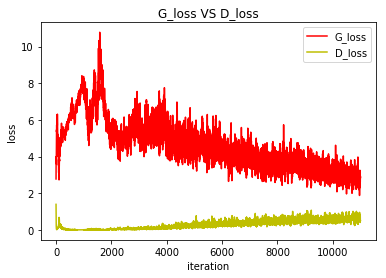

epoch : 25


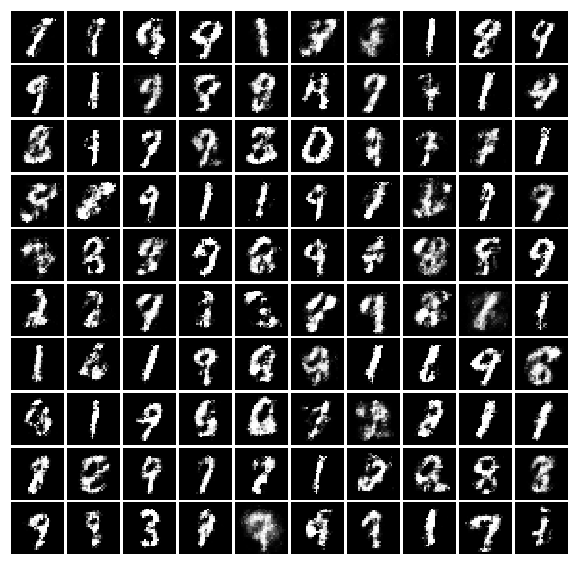

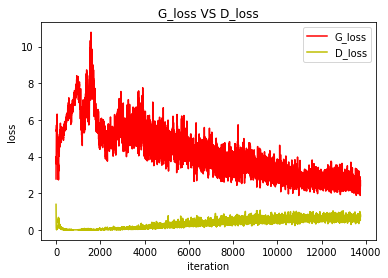

epoch : 30


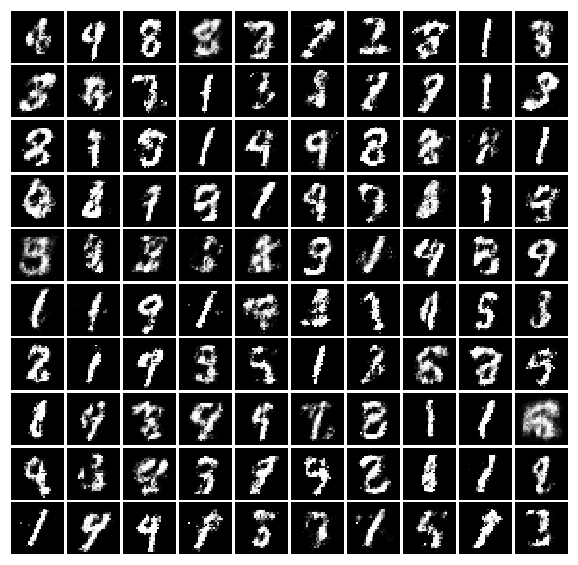

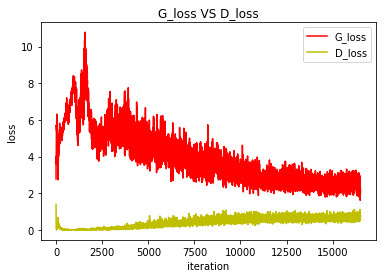

epoch : 35


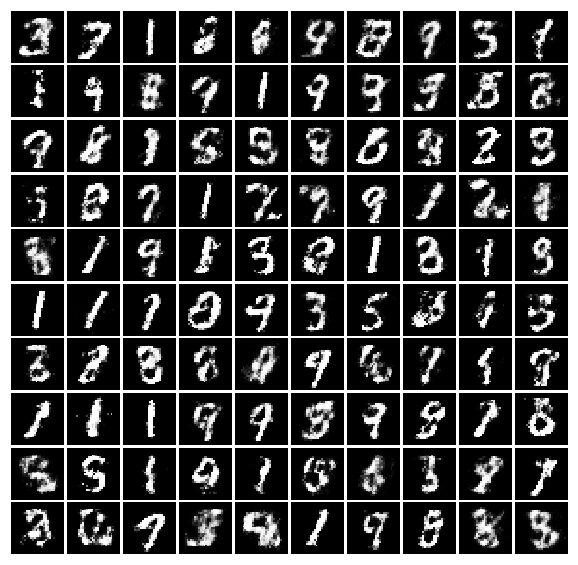

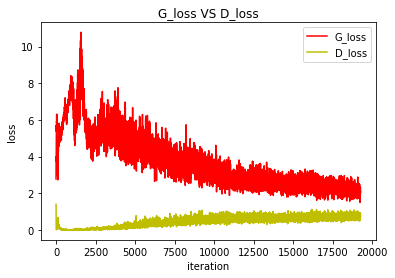

epoch : 40


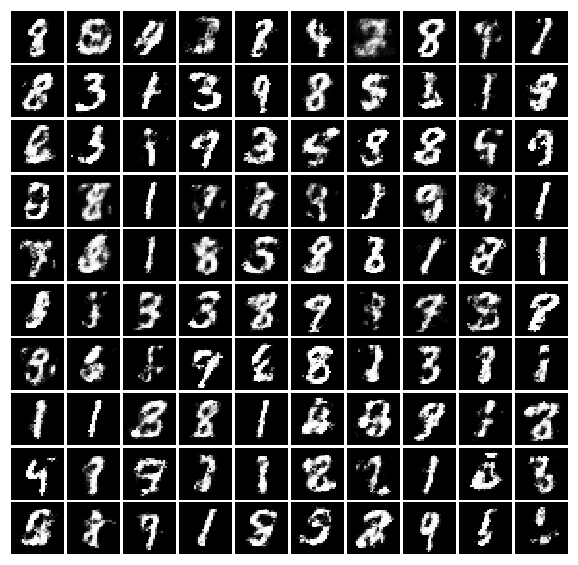

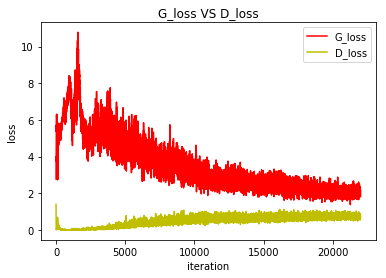

epoch : 45


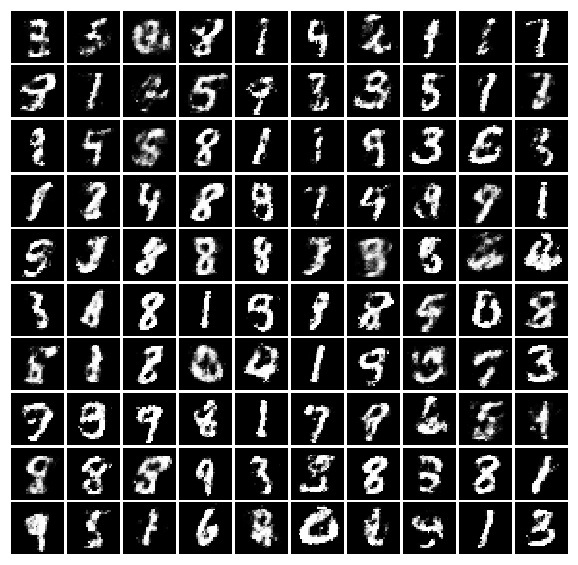

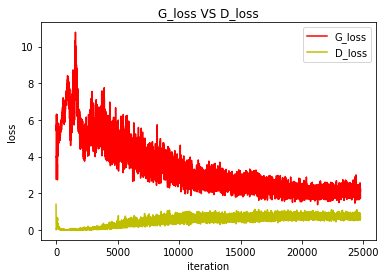

epoch : 50


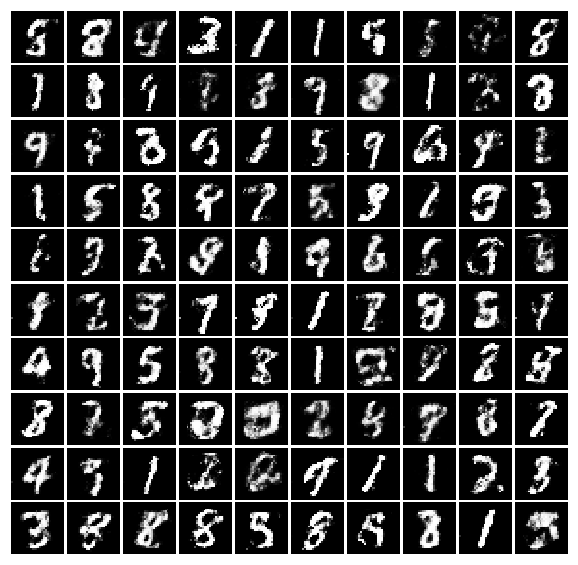

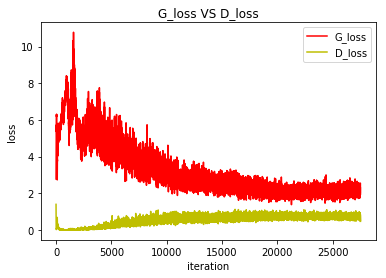

epoch : 55


KeyboardInterrupt: 

In [5]:
# load data
mnist = tf.contrib.learn.datasets.mnist.read_data_sets(
    train_dir='mnist/data', one_hot=True)

gan = GAN()
model_config = ModelConfig()

G_iteration_list = []
G_loss_list = []
D_iteration_list = []
D_loss_list = []
k_run_times = 0
r_run_times = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch_idx in range(model_config.max_epoch):
        if epoch_idx % model_config.plot_epoch == 0:
            samples = sess.run(
                gan.G_sample,
                feed_dict={
                    gan.Z:
                    gan.sample.uniform_sample(model_config.batch_size,
                                              model_config.z_dim)
                })
            print("epoch : {}".format(epoch_idx))
            sample_fig = plot_sample(samples)
            plt.show()
            plt.close(sample_fig)

            loss_fig = plot_loss(G_iteration_list, G_loss_list,
                                 D_iteration_list, D_loss_list)
            plt.show()
            plt.close(loss_fig)

        for batch_idx in range(
                mnist.train.num_examples // model_config.batch_size):
            X_mb, _ = mnist.train.next_batch(model_config.batch_size)

            for k in range(model_config.K):
                _, D_loss_curr = sess.run(
                    [gan.D_solver, gan.D_loss],
                    feed_dict={
                        gan.X:
                        X_mb,
                        gan.Z:
                        gan.sample.uniform_sample(model_config.batch_size,
                                                  model_config.z_dim)
                    })
                k_run_times += 1
                D_iteration_list.append(k_run_times)
                D_loss_list.append(D_loss_curr)

            for r in range(model_config.R):
                _, G_loss_curr = sess.run(
                    [gan.G_solver, gan.G_loss],
                    feed_dict={
                        gan.Z:
                        gan.sample.uniform_sample(model_config.batch_size,
                                                  model_config.z_dim)
                    })
                r_run_times += 1
                G_iteration_list.append(r_run_times)
                G_loss_list.append(G_loss_curr)